In [1]:
# Jupyter Notebook: Preprocesado de IEMOCAP para Speech Emotion Recognition
# ================================================================
# ESTE CÓDIGO INCLUYE LA DIVISIÓN DE DATOS EN: TRAIN (Ses. 1-3), VAL (Ses. 4), TEST (Ses. 5)

# ------------------------------------------------
# 0. Imports
# ------------------------------------------------
import os
import re
import csv
import pandas as pd # Necesario para guardar los CSV divididos fácilmente
from pathlib import Path
import soundfile as sf
import librosa
import numpy as np
from tqdm import tqdm
import shutil

# ------------------------------------------------
# 1. Configuración
# ------------------------------------------------
IEMOCAP_ROOT = Path("./IEMOCAP_LITE")  # <-- CAMBIA ESTO
OUTPUT_ROOT = Path("processed_iemocap")
OUTPUT_ROOT.mkdir(exist_ok=True)

SAMPLE_RATE = 16000

# Emociones a usar (estándar en SER)
VALID_EMOTIONS = {
    "ang": "ang",
    "hap": "hap",
    "exc": "hap",    # excitement se mapea a happy
    "sad": "sad",
    "neu": "neu",
    # EXCLUIDA: "fru": "fru" (Frustration, a menudo excluida para 4-clases)
}

# ------------------------------------------------
# 2. Parser de archivos EmoEvaluation (Sin cambios)
# ------------------------------------------------
line_pattern = re.compile(
    r"\[(?P<start>\d+\.\d+) - (?P<end>\d+\.\d+)\]\s+"
    r"(?P<utt>\S+)\s+(?P<emo>\S+)"
)

def parse_emoeval(txt_path):
    records = []
    with open(txt_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            match = line_pattern.search(line)
            if match:
                emo = match.group("emo")
                # Solo incluimos emociones que estén en nuestro conjunto VALID_EMOTIONS
                if emo in VALID_EMOTIONS:
                    records.append({
                        "utterance": match.group("utt"),
                        "start": float(match.group("start")),
                        "end": float(match.group("end")),
                        "emotion": VALID_EMOTIONS[emo]
                    })
    return records

# ------------------------------------------------
# 3. Procesamiento (Mantiene el preprocesamiento)
# ------------------------------------------------
metadata = []

# Recorremos las sesiones encontradas
sessions = sorted(IEMOCAP_ROOT.glob("Session*"))
print(f"Sesiones encontradas: {[s.name for s in sessions]}")

for session_dir in sessions:
    session_id = session_dir.name
    
    # Rutas típicas de IEMOCAP
    emo_dir = session_dir / "dialog" / "EmoEvaluation"
    sentences_dir = session_dir / "sentences" / "wav"

    if not emo_dir.exists() or not sentences_dir.exists():
        print(f"⚠️ Saltando {session_id}: No se encuentran carpetas 'EmoEvaluation' o 'sentences/wav'")
        continue

    # Procesamos cada archivo de evaluación
    for emo_file in tqdm(list(emo_dir.glob("*.txt")), desc=f"Procesando {session_id}"):
        records = parse_emoeval(emo_file)
        if not records:
            continue

        dialog_name = emo_file.stem
        src_wav_folder = sentences_dir / dialog_name
        
        if not src_wav_folder.exists():
            continue

        for r in records:
            utt_name = r["utterance"]
            emotion = r["emotion"]
            
            src_wav_path = src_wav_folder / f"{utt_name}.wav"
            
            if not src_wav_path.exists():
                continue

            # --- Preparar destino y guardar el audio ---
            emo_out_dir = OUTPUT_ROOT / emotion
            emo_out_dir.mkdir(exist_ok=True)
            dst_wav_path = emo_out_dir / f"{utt_name}.wav"

            try:
                # Re-samplear con Librosa y guardar
                y, sr = librosa.load(src_wav_path, sr=SAMPLE_RATE)
                sf.write(dst_wav_path, y, SAMPLE_RATE)

                # Guardar metadatos
                speaker = utt_name[4] if len(utt_name) > 4 else "X"
                metadata.append({
                    "wav_path": str(dst_wav_path.resolve()), # Ruta absoluta para mayor seguridad
                    "emotion": emotion,
                    "speaker": speaker,
                    "session": session_id
                })
            except Exception as e:
                print(f"Error procesando {utt_name}: {e}")

# ------------------------------------------------
# 4. Guardar CSV DIVIDIDOS (Train, Val, Test)
# ------------------------------------------------
if len(metadata) > 0:
    df = pd.DataFrame(metadata)
    
    # Aseguramos que la columna 'session' sea una cadena simple
    df['session'] = df['session'].astype(str)
    
    # Definición de las divisiones
    # Train: Sesiones 1, 2, 3
    # Validation: Sesión 4
    # Test: Sesión 5
    
    train_sessions = ['Session1', 'Session2', 'Session3']
    val_sessions = ['Session4']
    test_sessions = ['Session5']
    
    # Filtrado de DataFrames
    train_df = df[df['session'].isin(train_sessions)].reset_index(drop=True)
    val_df = df[df['session'].isin(val_sessions)].reset_index(drop=True)
    test_df = df[df['session'].isin(test_sessions)].reset_index(drop=True)
    
    # Guardar los CSV
    train_df.to_csv(OUTPUT_ROOT / "iemocap_train.csv", index=False)
    val_df.to_csv(OUTPUT_ROOT / "iemocap_val.csv", index=False)
    test_df.to_csv(OUTPUT_ROOT / "iemocap_test.csv", index=False)
    
    print(f"\n✅ ¡ÉXITO! División completa en {len(metadata)} audios.")
    print(f"   - Train (Ses. 1-3): {len(train_df)} muestras -> iemocap_train.csv")
    print(f"   - Val (Ses. 4): {len(val_df)} muestras -> iemocap_val.csv")
    print(f"   - Test (Ses. 5): {len(test_df)} muestras -> iemocap_test.csv")
else:
    print("\n❌ ERROR: No se procesó ningún archivo.")

Sesiones encontradas: ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']


Procesando Session5: 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


✅ ¡ÉXITO! División completa en 5531 audios.
   - Train (Ses. 1-3): 3259 muestras -> iemocap_train.csv
   - Val (Ses. 4): 1031 muestras -> iemocap_val.csv
   - Test (Ses. 5): 1241 muestras -> iemocap_test.csv


--- 📂 Cargando DataFrames Divididos ---
✅ Train: 3259 muestras cargadas.
✅ Validation: 1031 muestras cargadas.
✅ Test: 1241 muestras cargadas.

--- Análisis de Duración (Train, N=1000 muestras) ---


Calculando duración en Train:   0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_776326/2293292586.py:59: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=wav_path)
Calculando duración en Train: 100%|██████████| 1000/1000 [00:06<00:00, 162.61it/s]



📊 Estadísticas de Duración (Train):
   Duración Mínima: 0.58s
   Duración Media:  4.70s
   Duración Máxima: 29.13s
   Percentil 95 (P95): 11.14s
   Archivos con error: 0


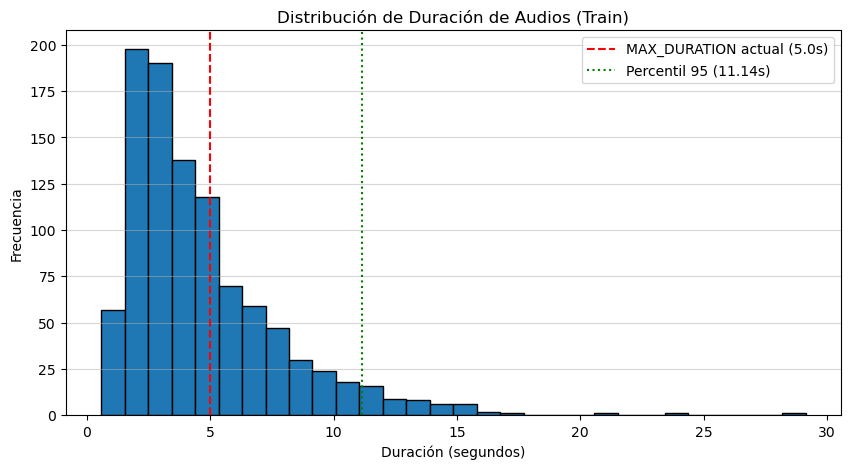


💡 Recomendación para Train:
   Considera aumentar MAX_DURATION a al menos 11.14s

--- Análisis de Duración (Validation, N=1000 muestras) ---


Calculando duración en Validation:   0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_776326/2293292586.py:59: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=wav_path)
Calculando duración en Validation: 100%|██████████| 1000/1000 [00:05<00:00, 183.20it/s]



📊 Estadísticas de Duración (Validation):
   Duración Mínima: 0.76s
   Duración Media:  4.42s
   Duración Máxima: 24.36s
   Percentil 95 (P95): 10.11s
   Archivos con error: 0


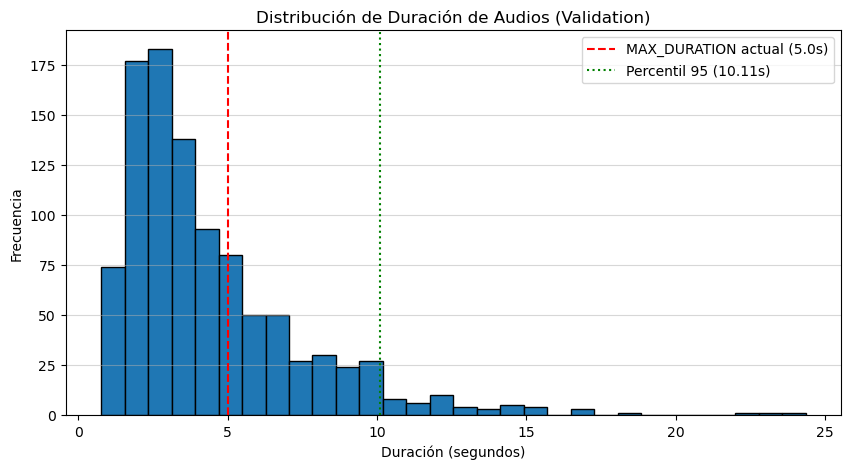


💡 Recomendación para Validation:
   Considera aumentar MAX_DURATION a al menos 10.11s

--- Análisis de Duración (Test, N=1000 muestras) ---


Calculando duración en Test:   0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_776326/2293292586.py:59: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=wav_path)
Calculando duración en Test: 100%|██████████| 1000/1000 [00:05<00:00, 178.84it/s]



📊 Estadísticas de Duración (Test):
   Duración Mínima: 0.78s
   Duración Media:  4.43s
   Duración Máxima: 34.14s
   Percentil 95 (P95): 11.31s
   Archivos con error: 0


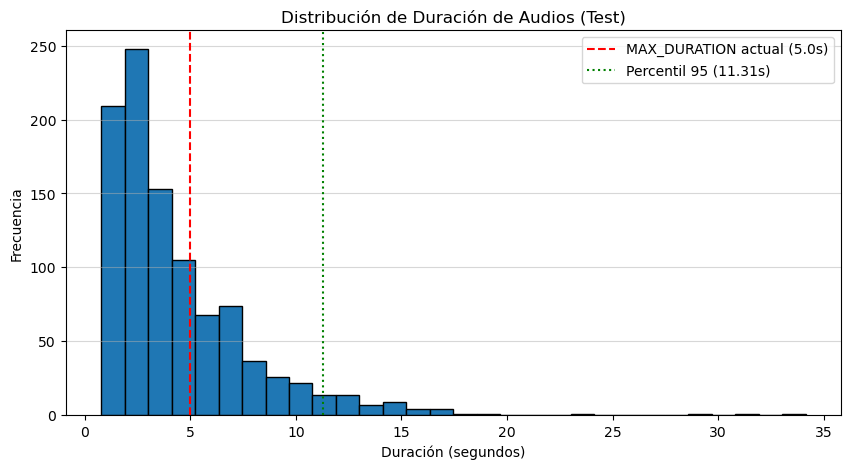


💡 Recomendación para Test:
   Considera aumentar MAX_DURATION a al menos 11.31s

✅ Análisis de duración completado.

📈 RESUMEN GENERAL:
   Train: P95 = 11.14s | Errores: 0
   Validation: P95 = 10.11s | Errores: 0
   Test: P95 = 11.31s | Errores: 0


In [2]:
# =============================================================================
# CÓDIGO COMPLETO DE VERIFICACIÓN Y ANÁLISIS DE DURACIÓN DE AUDIOS
# =============================================================================

import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import os

# ------------------------------------------------
# 1. Configuración de Rutas y Parámetros
# ------------------------------------------------
OUTPUT_ROOT = Path("processed_iemocap")
FILES = {
    'Train': OUTPUT_ROOT / "iemocap_train.csv",
    'Validation': OUTPUT_ROOT / "iemocap_val.csv",
    'Test': OUTPUT_ROOT / "iemocap_test.csv"
}

# Valor actual de referencia que usas en el entrenamiento
CURRENT_MAX_DURATION = 5.0 

# ------------------------------------------------
# 2. Cargar DataFrames
# ------------------------------------------------
dataframes = {}
print("--- 📂 Cargando DataFrames Divididos ---")
for name, path in FILES.items():
    if path.exists():
        try:
            df = pd.read_csv(path)
            dataframes[name] = df
            print(f"✅ {name}: {len(df)} muestras cargadas.")
        except Exception as e:
            print(f"❌ Error al cargar {name}: {e}")
    else:
        print(f"❌ ERROR: Archivo no encontrado: {path}. ¡Ejecuta el preprocesamiento primero!")

# ------------------------------------------------
# 3. Función de Análisis y Visualización
# ------------------------------------------------
def analyze_duration(df, name):
    durations = []
    error_files = []
    
    # Tomamos una muestra aleatoria de hasta 1000 audios para acelerar el cálculo
    N_samples = min(len(df), 1000)
    sample_df = df.sample(N_samples, random_state=42)
    
    print(f"\n--- Análisis de Duración ({name}, N={N_samples} muestras) ---")
    
    # Calcular la duración de cada audio usando librosa.get_duration()
    for wav_path in tqdm(sample_df['wav_path'], desc=f"Calculando duración en {name}"):
        try:
            # Opción 1: Usar librosa.get_duration() - más eficiente
            duration = librosa.get_duration(filename=wav_path)
            durations.append(duration)
        except Exception as e:
            # Manejar errores de archivos corruptos o rutas incorrectas
            error_files.append(wav_path)
            print(f"\n⚠️ Error al obtener duración de {wav_path}: {e}")
            pass
            
    if durations:
        durations = pd.Series(durations)
        
        # Capturar y reportar la Duración Máxima y el P95
        max_dur = durations.max()
        p95_dur = durations.quantile(0.95)

        # Reporte de Estadísticas
        print(f"\n📊 Estadísticas de Duración ({name}):")
        print(f"   Duración Mínima: {durations.min():.2f}s")
        print(f"   Duración Media:  {durations.mean():.2f}s")
        print(f"   Duración Máxima: {max_dur:.2f}s")
        print(f"   Percentil 95 (P95): {p95_dur:.2f}s")
        print(f"   Archivos con error: {len(error_files)}")
        
        # Visualización de la distribución
        plt.figure(figsize=(10, 5))
        plt.hist(durations, bins=30, color='#1f77b4', edgecolor='black')
        plt.title(f'Distribución de Duración de Audios ({name})')
        plt.xlabel('Duración (segundos)')
        plt.ylabel('Frecuencia')
        
        # Líneas de referencia
        plt.axvline(x=CURRENT_MAX_DURATION, color='r', linestyle='--', 
                    label=f'MAX_DURATION actual ({CURRENT_MAX_DURATION}s)')
        plt.axvline(x=p95_dur, color='green', linestyle=':', 
                    label=f'Percentil 95 ({p95_dur:.2f}s)')
        
        plt.legend()
        plt.grid(axis='y', alpha=0.5)
        plt.show()
        
        # Recomendación
        print(f"\n💡 Recomendación para {name}:")
        if p95_dur > CURRENT_MAX_DURATION:
            print(f"   Considera aumentar MAX_DURATION a al menos {p95_dur:.2f}s")
        else:
            print(f"   MAX_DURATION actual de {CURRENT_MAX_DURATION}s es adecuado")
        
        # Mostrar algunos archivos problemáticos si existen
        if error_files:
            print(f"\n⚠️ Archivos con errores (primeros 5):")
            for i, f in enumerate(error_files[:5]):
                print(f"   {i+1}. {f}")
                
        return durations, error_files
    else:
        print(f"\n❌ No se pudieron calcular duraciones para {name}")
        return None, error_files

# ------------------------------------------------
# 4. Ejecutar el Análisis
# ------------------------------------------------
if dataframes:
    all_durations = {}
    all_errors = {}
    
    for name, df in dataframes.items():
        durations, errors = analyze_duration(df, name)
        all_durations[name] = durations
        all_errors[name] = errors
    
    print("\n" + "="*50)
    print("✅ Análisis de duración completado.")
    print("="*50)
    
    # Resumen general
    print("\n📈 RESUMEN GENERAL:")
    for name in dataframes.keys():
        if all_durations[name] is not None:
            p95 = all_durations[name].quantile(0.95)
            print(f"   {name}: P95 = {p95:.2f}s | Errores: {len(all_errors[name])}")

In [3]:
ls

'Fine Tuning Teacher.ipynb'   core                           processed_iemocap/
 IEMOCAP_DATA/                entrenamieto.ipynb             temp_ghostnet.pth
 IEMOCAP_LITE/                environment.yml                temp_mobileone.pth
 RAVDESS_DATA/                iemocap_hf_student_ready.csv   temp_repvgg.pth
 Untitled.ipynb              'procesando datos.ipynb'        test_model.ipynb


In [3]:
# =============================================================================
# SCRIPT 1B: PREPROCESAMIENTO RAVDESS
# Nota: La ruta RAVDESS_ROOT debe apuntar a la carpeta que contiene Actor_01...
# =============================================================================

import os
import pandas as pd
from pathlib import Path
import soundfile as sf
import librosa
from tqdm import tqdm

# ------------------------------------------------
# 1. Configuración
# ------------------------------------------------
# **¡IMPORTANTE!** Asegúrate de que esta ruta sea correcta
RAVDESS_ROOT = Path("./RAVDESS") 
OUTPUT_ROOT = Path("processed_ravdess") # Esto creará processed_ravdess/
OUTPUT_ROOT.mkdir(exist_ok=True)

SAMPLE_RATE = 16000
TARGET_CSV = OUTPUT_ROOT / "ravdess_metadata.csv"

# Mapeo de emociones (Solo usaremos las 4 clases de IEMOCAP)
EMOTION_MAP = {
    '01': 'neu', # Neutral
    '03': 'hap', # Happy
    '04': 'sad', # Sad
    '05': 'ang', # Angry
    # Ignoramos 02=calm, 06=fearful, 07=disgust, 08=surprised
}

# ------------------------------------------------
# 2. Procesamiento y Extracción de Metadatos
# ------------------------------------------------
metadata = []

actor_dirs = sorted(RAVDESS_ROOT.glob("Actor_*"))

for actor_dir in tqdm(actor_dirs, desc="Procesando Actores RAVDESS"):
    actor_id = actor_dir.name
    
    for src_wav_path in actor_dir.glob("*.wav"):
        filename_parts = src_wav_path.stem.split('-')
        
        # El código de emoción es el tercer elemento (índice 2)
        emotion_code = filename_parts[2]
        
        if emotion_code in EMOTION_MAP:
            emotion = EMOTION_MAP[emotion_code]
            utt_name = src_wav_path.stem
            
            emo_out_dir = OUTPUT_ROOT / emotion
            emo_out_dir.mkdir(exist_ok=True)
            dst_wav_path = emo_out_dir / f"{utt_name}.wav"
            
            try:
                # Re-samplear a 16kHz y guardar
                y, sr = librosa.load(src_wav_path, sr=SAMPLE_RATE)
                sf.write(dst_wav_path, y, SAMPLE_RATE)

                metadata.append({
                    "wav_path": str(dst_wav_path.resolve()), 
                    "emotion": emotion,
                    "speaker": actor_id,
                    "session": "RAVDESS"
                })
            except Exception as e:
                # Este error es común si hay archivos dañados
                print(f"Error procesando {utt_name}: {e}")

# ------------------------------------------------
# 3. Guardar CSV
# ------------------------------------------------
if len(metadata) > 0:
    df = pd.DataFrame(metadata)
    df.to_csv(TARGET_CSV, index=False)
    
    print(f"\n✅ ¡ÉXITO! Preprocesamiento RAVDESS completo.")
    print(f"   - Total muestras (4 clases): {len(df)} audios.")
    print(f"   - CSV guardado en: {TARGET_CSV}")
else:
    print("\n❌ ERROR: No se procesó ningún archivo de RAVDESS.")

Procesando Actores RAVDESS: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


✅ ¡ÉXITO! Preprocesamiento RAVDESS completo.
   - Total muestras (4 clases): 672 audios.
   - CSV guardado en: processed_ravdess/ravdess_metadata.csv


In [4]:
# =============================================================================
# SCRIPT DE CONSOLIDACIÓN: MEZCLA IEMOCAP TRAIN + RAVDESS (TEACHER)
# =============================================================================

import pandas as pd
from pathlib import Path
import shutil

# ------------------------------------------------
# 1. Configuración de Rutas
# ------------------------------------------------
# Rutas de origen (Archivos que ya tienes)
IEMOCAP_ROOT = Path("processed_iemocap")
RAVDESS_ROOT = Path("processed_ravdess")

IEMOCAP_TRAIN_CSV = IEMOCAP_ROOT / "iemocap_train.csv"
IEMOCAP_VAL_CSV = IEMOCAP_ROOT / "iemocap_val.csv"
IEMOCAP_TEST_CSV = IEMOCAP_ROOT / "iemocap_test.csv"
RAVDESS_METADATA_CSV = RAVDESS_ROOT / "ravdess_metadata.csv"

# Nueva carpeta de salida para el Teacher Combinado
COMBINED_OUTPUT_DIR = Path("processed_combined_teacher")
COMBINED_OUTPUT_DIR.mkdir(exist_ok=True)

# ------------------------------------------------
# 2. Carga y Consolidación
# ------------------------------------------------

print("--- 📂 Iniciando Consolidación de Datasets ---")

try:
    # Cargar IEMOCAP
    df_iemocap_train = pd.read_csv(IEMOCAP_TRAIN_CSV)
    df_iemocap_val = pd.read_csv(IEMOCAP_VAL_CSV)
    df_iemocap_test = pd.read_csv(IEMOCAP_TEST_CSV)
    print(f"✅ IEMOCAP cargado: Train={len(df_iemocap_train)}, Val={len(df_iemocap_val)}, Test={len(df_iemocap_test)}")

    # Cargar RAVDESS
    df_ravdess = pd.read_csv(RAVDESS_METADATA_CSV)
    print(f"✅ RAVDESS cargado: {len(df_ravdess)} muestras.")

    # 3. CREAR EL CONJUNTO DE ENTRENAMIENTO COMBINADO
    df_train_combined = pd.concat([df_iemocap_train, df_ravdess], ignore_index=True)
    
    # Mezclamos el DataFrame combinado para asegurar que los batches no sean solo IEMOCAP o solo RAVDESS
    df_train_combined = df_train_combined.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"\n🎉 CONSOLIDACIÓN EXITOSA!")
    print(f"   - Train Combinado: IEMOCAP ({len(df_iemocap_train)}) + RAVDESS ({len(df_ravdess)}) = {len(df_train_combined)} muestras.")

except FileNotFoundError as e:
    print(f"\n❌ ERROR: Archivo no encontrado. ¿Ejecutaste el preprocesamiento de IEMOCAP y RAVDESS? Detalle: {e}")
    exit()

# ------------------------------------------------
# 4. Guardar los nuevos CSV
# ------------------------------------------------
# El Train combinado es nuevo
df_train_combined.to_csv(COMBINED_OUTPUT_DIR / "combined_train.csv", index=False)

# Val y Test se copian de IEMOCAP (sin RAVDESS)
df_iemocap_val.to_csv(COMBINED_OUTPUT_DIR / "combined_val.csv", index=False)
df_iemocap_test.to_csv(COMBINED_OUTPUT_DIR / "combined_test.csv", index=False)

print(f"\n💾 Archivos guardados en la nueva ruta: {COMBINED_OUTPUT_DIR.resolve()}")
print("   - combined_train.csv (Contiene ambos datasets)")
print("   - combined_val.csv (Solo IEMOCAP Sesión 4)")
print("   - combined_test.csv (Solo IEMOCAP Sesión 5)")

# ------------------------------------------------
# 5. ACTUALIZAR EL SCRIPT DE ENTRENAMIENTO
# ------------------------------------------------
print("\n--- 🛠️ PASO FINAL: ACTUALIZAR EL SCRIPT DE ENTRENAMIENTO ---")
print("El script 'train_wavlm_hf.py' ahora debe usar 'combined_train.csv' y 'combined_val.csv'.")

--- 📂 Iniciando Consolidación de Datasets ---
✅ IEMOCAP cargado: Train=3259, Val=1031, Test=1241
✅ RAVDESS cargado: 672 muestras.

🎉 CONSOLIDACIÓN EXITOSA!
   - Train Combinado: IEMOCAP (3259) + RAVDESS (672) = 3931 muestras.

💾 Archivos guardados en la nueva ruta: /workspace/notebooks/Carlos/Audio/processed_combined_teacher
   - combined_train.csv (Contiene ambos datasets)
   - combined_val.csv (Solo IEMOCAP Sesión 4)
   - combined_test.csv (Solo IEMOCAP Sesión 5)

--- 🛠️ PASO FINAL: ACTUALIZAR EL SCRIPT DE ENTRENAMIENTO ---
El script 'train_wavlm_hf.py' ahora debe usar 'combined_train.csv' y 'combined_val.csv'.


--- 📂 Cargando DataFrames Combinados ---
✅ Train_Combined: 3931 muestras cargadas.
✅ Validation_IEMOCAP: 1031 muestras cargadas.
✅ Test_IEMOCAP: 1241 muestras cargadas.

--- Análisis de Duración (Train_Combined, N=1000 muestras) ---


Calculando duración en Train_Combined: 100%|██████████| 1000/1000 [00:00<00:00, 14287.87it/s]


📊 Estadísticas de Duración (Train_Combined):
    Duración Mínima: 0.58s
    Duración Media:  4.37s
    Duración Máxima: 18.92s
    Percentil 95 (P95): 9.91s
    Archivos con error: 0


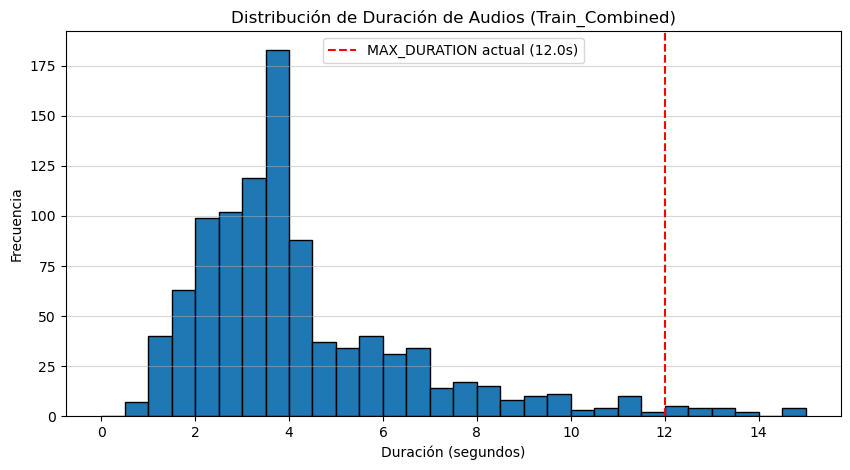


💡 Recomendación para Train_Combined:
    ✅ MAX_DURATION actual de 12.0s es adecuado.

--- Análisis de Duración (Validation_IEMOCAP, N=1000 muestras) ---


Calculando duración en Validation_IEMOCAP: 100%|██████████| 1000/1000 [00:00<00:00, 14240.33it/s]



📊 Estadísticas de Duración (Validation_IEMOCAP):
    Duración Mínima: 0.76s
    Duración Media:  4.42s
    Duración Máxima: 24.36s
    Percentil 95 (P95): 10.11s
    Archivos con error: 0


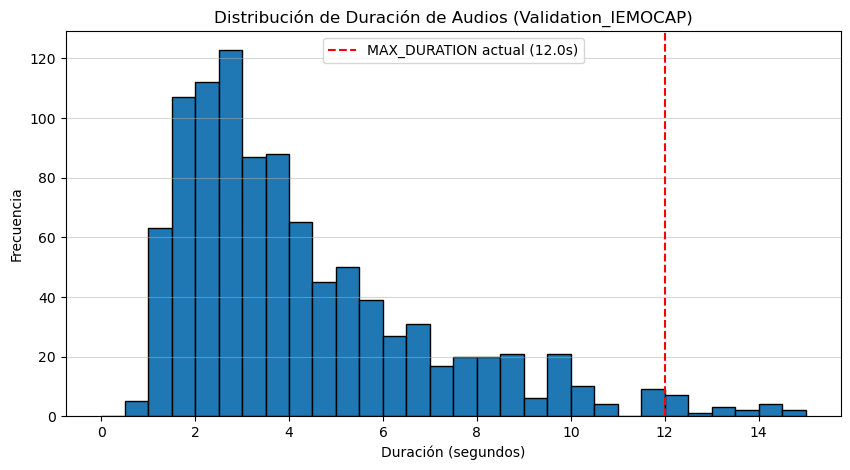


💡 Recomendación para Validation_IEMOCAP:
    ✅ MAX_DURATION actual de 12.0s es adecuado.

--- Análisis de Duración (Test_IEMOCAP, N=1000 muestras) ---


Calculando duración en Test_IEMOCAP: 100%|██████████| 1000/1000 [00:00<00:00, 14308.49it/s]



📊 Estadísticas de Duración (Test_IEMOCAP):
    Duración Mínima: 0.78s
    Duración Media:  4.43s
    Duración Máxima: 34.14s
    Percentil 95 (P95): 11.31s
    Archivos con error: 0


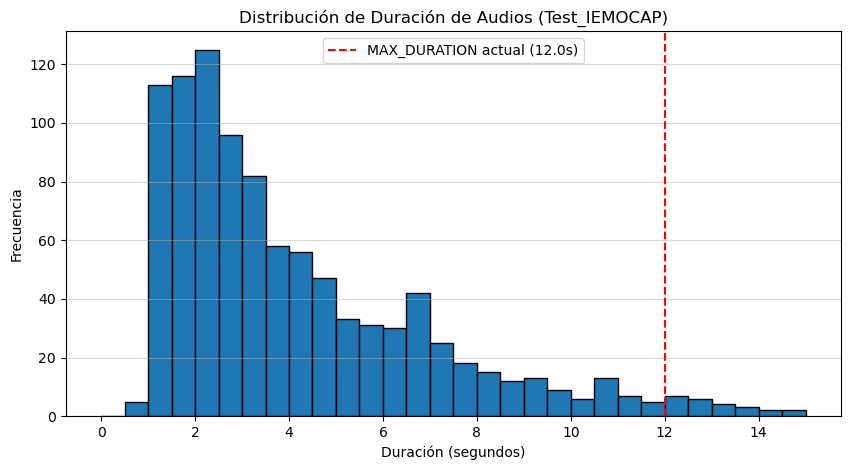


💡 Recomendación para Test_IEMOCAP:
    ✅ MAX_DURATION actual de 12.0s es adecuado.

✅ Análisis de duración completado.

📈 RESUMEN FINAL DE DURACIÓN:
    Train_Combined: P95 = 9.91s | Media = 4.37s | Máx = 18.92s
    Validation_IEMOCAP: P95 = 10.11s | Media = 4.42s | Máx = 24.36s
    Test_IEMOCAP: P95 = 11.31s | Media = 4.43s | Máx = 34.14s


In [6]:
# =============================================================================
# CÓDIGO ACTUALIZADO: ANÁLISIS DE DURACIÓN PARA EL TEACHER COMBINADO
# =============================================================================

import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import os
import warnings

# Suprimir la advertencia de desuso de librosa
warnings.filterwarnings("ignore", category=FutureWarning)

# ------------------------------------------------
# 1. Configuración de Rutas y Parámetros
# ------------------------------------------------
# RUTA ACTUALIZADA a la carpeta donde guardaste los archivos combinados
OUTPUT_ROOT = Path("processed_combined_teacher") 

FILES = {
    # Train: Contiene IEMOCAP (Ses. 1-3) + RAVDESS
    'Train_Combined': OUTPUT_ROOT / "combined_train.csv",
    # Validation y Test: Solo contienen IEMOCAP (Ses. 4 y 5)
    'Validation_IEMOCAP': OUTPUT_ROOT / "combined_val.csv", 
    'Test_IEMOCAP': OUTPUT_ROOT / "combined_test.csv"
}

# Valor actual de referencia (debe coincidir con tu configuración de WavLM)
CURRENT_MAX_DURATION = 12.0 

# ------------------------------------------------
# 2. Cargar DataFrames
# ------------------------------------------------
dataframes = {}
print("--- 📂 Cargando DataFrames Combinados ---")
for name, path in FILES.items():
    if path.exists():
        try:
            df = pd.read_csv(path)
            dataframes[name] = df
            print(f"✅ {name}: {len(df)} muestras cargadas.")
        except Exception as e:
            print(f"❌ Error al cargar {name}: {e}")
    else:
        print(f"❌ ERROR: Archivo no encontrado: {path}.")

# ------------------------------------------------
# 3. Función de Análisis y Visualización
# ------------------------------------------------
def analyze_duration(df, name):
    durations = []
    error_files = []
    
    # Tomamos una muestra aleatoria de hasta 1000 audios o el total
    N_samples = min(len(df), 1000)
    
    # Muestrear solo el 10% si el conjunto combinado es muy grande (ej. > 10000)
    if len(df) > 5000:
         N_samples = int(len(df) * 0.1)
    
    sample_df = df.sample(N_samples, random_state=42)
    
    print(f"\n--- Análisis de Duración ({name}, N={N_samples} muestras) ---")
    
    # Calcular la duración de cada audio
    for wav_path in tqdm(sample_df['wav_path'], desc=f"Calculando duración en {name}"):
        try:
            # Usar librosa.get_duration()
            duration = librosa.get_duration(path=wav_path)
            durations.append(duration)
        except Exception as e:
            error_files.append(wav_path)
            # print(f"\n⚠️ Error al obtener duración de {wav_path}: {e}") # Desactivado para no saturar la salida
            pass
            
    if durations:
        durations = pd.Series(durations)
        
        max_dur = durations.max()
        p95_dur = durations.quantile(0.95)

        # Reporte de Estadísticas
        print(f"\n📊 Estadísticas de Duración ({name}):")
        print(f"    Duración Mínima: {durations.min():.2f}s")
        print(f"    Duración Media:  {durations.mean():.2f}s")
        print(f"    Duración Máxima: {max_dur:.2f}s")
        print(f"    Percentil 95 (P95): {p95_dur:.2f}s")
        print(f"    Archivos con error: {len(error_files)}")
        
        # Visualización de la distribución
        plt.figure(figsize=(10, 5))
        plt.hist(durations, bins=30, range=(0, 15), color='#1f77b4', edgecolor='black') # Rango limitado a 15s para mejor visualización
        plt.title(f'Distribución de Duración de Audios ({name})')
        plt.xlabel('Duración (segundos)')
        plt.ylabel('Frecuencia')
        
        # Líneas de referencia
        plt.axvline(x=CURRENT_MAX_DURATION, color='r', linestyle='--', 
                    label=f'MAX_DURATION actual ({CURRENT_MAX_DURATION}s)')
        
        plt.legend()
        plt.grid(axis='y', alpha=0.5)
        plt.show()
        
        
        # Recomendación
        print(f"\n💡 Recomendación para {name}:")
        if p95_dur > CURRENT_MAX_DURATION:
            print(f"    ⚠️ El P95 ({p95_dur:.2f}s) supera MAX_DURATION. Considera aumentarlo.")
        else:
            print(f"    ✅ MAX_DURATION actual de {CURRENT_MAX_DURATION}s es adecuado.")
            
        return durations, error_files
    else:
        print(f"\n❌ No se pudieron calcular duraciones para {name}")
        return None, error_files

# ------------------------------------------------
# 4. Ejecutar el Análisis
# ------------------------------------------------
if dataframes:
    all_durations = {}
    all_errors = {}
    
    for name, df in dataframes.items():
        durations, errors = analyze_duration(df, name)
        all_durations[name] = durations
        all_errors[name] = errors
    
    print("\n" + "="*50)
    print("✅ Análisis de duración completado.")
    print("="*50)
    
    # Resumen general
    print("\n📈 RESUMEN FINAL DE DURACIÓN:")
    for name in dataframes.keys():
        if all_durations[name] is not None:
            p95 = all_durations[name].quantile(0.95)
            print(f"    {name}: P95 = {p95:.2f}s | Media = {all_durations[name].mean():.2f}s | Máx = {all_durations[name].max():.2f}s")